> Importation des bibiliothèques

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from functools import partial
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm_notebook as tqdm
import math
import datetime
import os

> importation des données du CAC40

In [3]:
Liste_donnees=os.listdir(r'C:\Users\Lenovo\Desktop\S4\Séries temporelles\TP1\DonCAC40\\')

data = []
for i in range(len(Liste_donnees)): 
    F='C:/Users/Lenovo/Desktop/S4/Séries temporelles/TP1/DonCAC40\\'+Liste_donnees[i]
    a = pd.read_csv(F, delimiter=',')
    a=a[(a['Date'] >='2019-01-01')]
    a = a.reset_index()
    a=a.dropna()  # supprimer les données manquantes
    data.append(a[a.columns[7]])

data_time = []

for i in range(len(Liste_donnees)): 
    F='C:/Users/Lenovo/Desktop/S4/Séries temporelles/TP1/DonCAC40\\'+Liste_donnees[i]
    a = pd.read_csv(F, delimiter=',')
    a=a[(a['Date'] >='2019-01-01')]
    a = a.reset_index()

    a=a.dropna()  # supprimer les données manquantes
    data_time.append(a[a.columns[1]])
    


In [4]:
#La fonction Y de notre variable cible
def Y(data):
    Z=[np.log(1+data[i]/data[i-1]) for i in range(1,len(data))]
    return(Z)

## Code méthode analytique

In [5]:
def estimationAB(X):
    
    n=len(X)
    hbar=np.zeros(n)
    Ybar=np.zeros(n)
    hbar_etoile=np.zeros(n)
    Ybar_etoile=np.zeros(n)
    A1_chap_nom=np.zeros(n)
    A2_chap_nom=np.zeros(n)
    A1_chap_denom=np.zeros(n)
    A2_chap_denom=np.zeros(n)
    A1_chap=np.zeros(n)
    A2_chap=np.zeros(n)
    B1_chap=np.zeros(n)
    B2_chap=np.zeros(n)


    for k0 in range(4,n-4):    
        Y=F(k0,n)
        hbar[k0]=(1/k0)*sum(np.log(np.array(sorted(X[:k0]))))
        Ybar[k0]=(1/k0)*sum(Y[:k0])
        hbar_etoile[k0]=(1/(n-k0))*sum(np.log(np.array(sorted(X[k0:]))))
        Ybar_etoile[k0]=(1/(n-k0))*sum(np.array(Y[k0:]))

        #estimation des A1 B1 A2 B2
        
        #estimation A1
        A1_chap_nom[k0]=sum((np.log(np.array(sorted(X[:k0])))-hbar[k0])*(np.array(Y[:k0])-np.array(Ybar[k0])))
        A1_chap_denom[k0]=sum((np.log(np.array(sorted(X[:k0])))-hbar[k0])**2)
        A1_chap[k0]=A1_chap_nom[k0]/A1_chap_denom[k0]
        
        #estimation B1
        B1_chap[k0]=Ybar[k0]-A1_chap[k0]*hbar[k0]
        
        #estimation A2
        A2_chap_nom[k0]=sum((np.log(np.array(sorted(X[k0:])))-hbar_etoile[k0])*(np.array(Y[k0:])-np.array(Ybar_etoile[k0])))
        A2_chap_denom[k0]=sum((np.log(sorted(X[k0:]))-hbar_etoile[k0])**2)
        A2_chap[k0]=A2_chap_nom[k0]/A2_chap_denom[k0]

        #estimation B2
        B2_chap[k0]=Ybar_etoile[k0]-A2_chap[k0]*hbar_etoile[k0]
        
    result=[A1_chap,B1_chap,A2_chap,B2_chap]
        
    return result

def ln(x):
    return np.log(x)
def MR(i,k0,n):
    if i <= k0:
        return (i-0.3)/(k0+0.4)
    else :
        return (i-k0-0.3)/(n-k0+0.4)
    
def F(k0,n):
    Zt=[ ln(-ln(1-MR(i,k0,n))) for i in range(1,n+1)] 
    return Zt

In [6]:
#Estimation des A1 B1 A2 B2 finaux

#Fonction qui calcul K*
def Calcul_K_Etoile(B1,A1,B2,A2,X):
     #Fonction qui renvoie le vecteur des Xhi_i,j(k0)

    def Calcul_Vect_E(k0,n,B1_k0,A1_k0,B2_k0,A2_k0,Y,X):
        Vect_E_k0=[]
        for i in range(0,k0):
            X1=sorted(X[:k0])
            Vect_E_k0.append(Y[i]-B1_k0-A1_k0*np.log(X1[i]))
        for i in range(k0,n):
            X2=sorted(X[k0:])
            Vect_E_k0.append(Y[i]-B2_k0-A2_k0*np.log(X2[i-k0]))
        return(Vect_E_k0)

#calcul de D avec k0, n et Vect_E_k0 qui représente un vecteur de taille n, où les k0 premier éléments correspondent aux Xhi_1,i(k0) 
#et les k0+1 à n représentent les Xhi_2,i(k0)

    def Calcul_D(k0,n,Vect_E_k0):
        D=0
        for i in range(0,k0) :    ## i va de 0 à k0-1, donc on récupère les éléments de vect_E de i allant de 1 à k0
            D=D+(Vect_E_k0[i])**2
        for i in range(k0,n):
            D=D+(Vect_E_k0[i])**2
                
        return(D)
        
    n=len(X)
    D=np.zeros(n-8)  #Pour avoir un vecteur D de la bonne taille
    for i in range(4,n-4):
        Y=F(i,n)
        D[i-4]=Calcul_D(i,n,Calcul_Vect_E(i,n,B1[i],A1[i],B2[i],A2[i],Y,X))
    
    k_etoile=np.argmin(D)+4
    return k_etoile


def estimation_finaleAB(X):
        
    A1=estimationAB(X)[0]
    B1=estimationAB(X)[1]
    A2=estimationAB(X)[2]
    B2=estimationAB(X)[3]
    k=Calcul_K_Etoile(B1,A1,B2,A2,X)
    
    result=[A1[k],B1[k],A2[k],B2[k]]
    return result
    
    

In [7]:
def First_Method_analytic(X):
    [A1t,B1t,A2t,B2t]=estimationAB(X)
    k=Calcul_K_Etoile(B1t,A1t,B2t,A2t,X)
    [A1,B1,A2,B2]=estimation_finaleAB(X)
    param1={"a1": math.exp(-B1/A1),"b1": A1,"a2": math.exp(-B2/A2),"b2": A2, "k*": k}
    return param1

## Code log Vraisemblance

In [8]:
#fonction qui estime le moment de rupture ainsi que les 4 parametres a1,a2,b1,b2 en fonction des données ainsi  estime k

def Second_Method_log_vrais(df):
    n = len(df)
    taille = np.infty
    Vect0 = [1,1,1,1]
    k = 0
    
    #On retourne log vrai semblance de la fonction
    def funct_2(df,k,param):
        return funct_1(df[:k],param[:2])+funct_1(df[k:],param[2:])
    
    
    def funct_1(df,param):
        taille = len(df)
        a1 , b1 = param[1] , param[0]
        coef = taille*np.log(b1) - b1*taille*np.log(a1)
        coef11 , coef21 = sum(np.log(np.array(df)))*(b1-1),sum((np.array(df)/a1)**b1)
        
        return -(coef + coef11 - coef21)
    
    for j in tqdm(range(4, n-4)):
        
        optim = minimize(lambda x: funct_2(df, j, x), Vect0, method="nelder-mead", tol=1e-10) 
        t = funct_2(df,j,optim.x)       
        if t<taille:
            taille = t
            k = j
    
    #la fonction à minimiser afin de trouver les parametres optimals
    optim1 = minimize(lambda x: funct_1(df[:k], x), Vect0[:2], method="nelder-mead", tol=1e-10)
    optim2 = minimize(lambda x: funct_1(df[k:], x), Vect0[2:], method="nelder-mead", tol=1e-10)
    
    #retourner les parametres à estimer a1,b1 ~ W1 
    #a2,b2 ~ W2 
    #ainsi le parametre k
    
    return {"a1": optim1.x[1],"b1": optim1.x[0],"a2":optim2.x[1],"b2": optim2.x[0], "k*": k}
    

## Test sur CAC40 méthode analytique et Vrai semblance


-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6961721118182392, 'b1': 121.63222772255446, 'a2': 0.7004689704665766, 'b2': 54.62963551168321, 'k*': 302}
{'a1': 0.6964344243303837, 'b1': 93.25858353576314, 'a2': 0.7010068087295767, 'b2': 31.60301433508034, 'k*': 300}


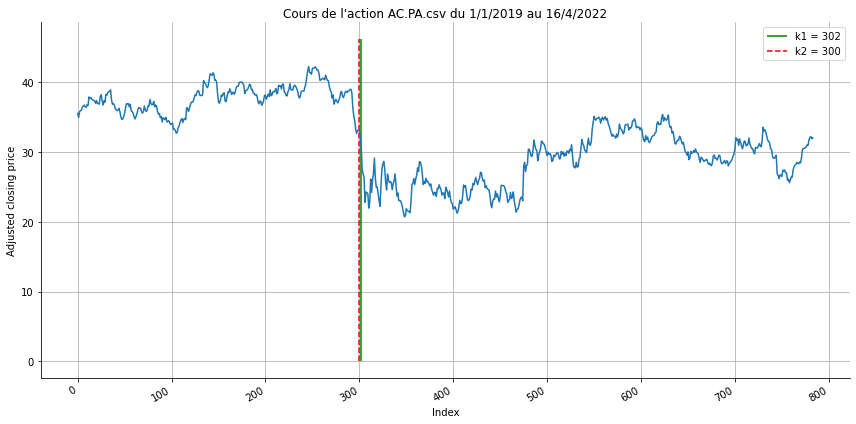

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6971520892917709, 'b1': 105.79328314199701, 'a2': 0.699998874166823, 'b2': 61.37947450973695, 'k*': 300}
{'a1': 0.6976734395926453, 'b1': 88.29415701370024, 'a2': 0.6997097391639624, 'b2': 45.39238253580429, 'k*': 292}


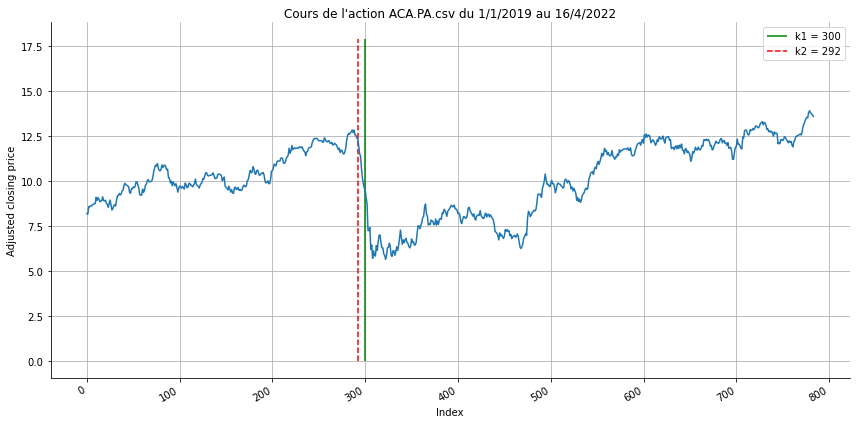

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6960244006089152, 'b1': 179.92989050432266, 'a2': 0.6969803691522273, 'b2': 107.9864371982268, 'k*': 292}
{'a1': 0.6961326738228182, 'b1': 150.1628661307238, 'a2': 0.6969965692938925, 'b2': 81.45297042062542, 'k*': 292}


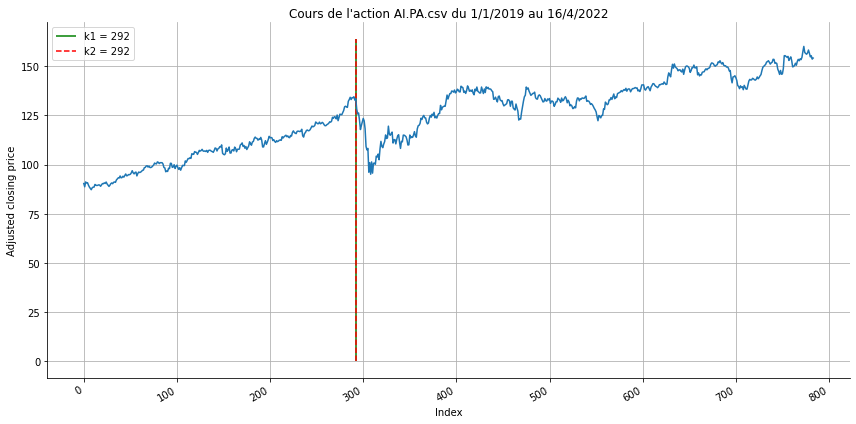

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6971880589730629, 'b1': 110.20157839029156, 'a2': 0.7021676701645942, 'b2': 44.65229570818013, 'k*': 298}
{'a1': 0.6975423466566303, 'b1': 93.74984900839678, 'a2': 0.7021598121362435, 'b2': 29.529169501217417, 'k*': 292}


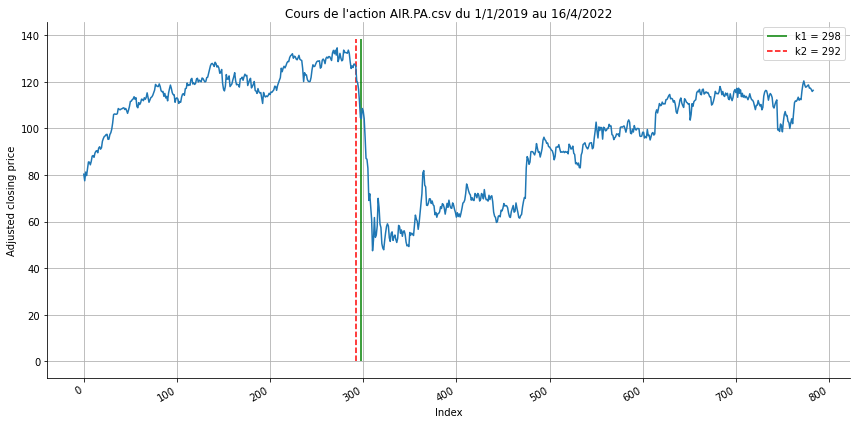

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6968531523889486, 'b1': 133.27138738996206, 'a2': 0.698346196091274, 'b2': 71.9825205296757, 'k*': 284}
{'a1': 0.6971245936068667, 'b1': 93.8283249560202, 'a2': 0.698688758393908, 'b2': 48.649418654668466, 'k*': 287}


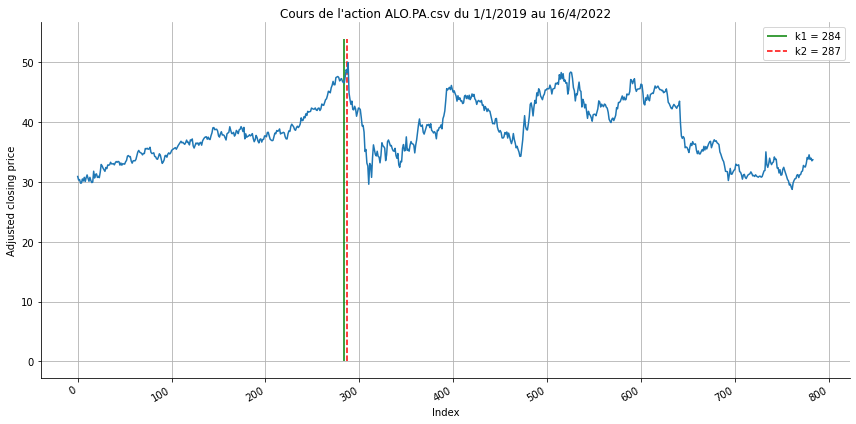

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6957948132097025, 'b1': 202.5276400679974, 'a2': 0.6965831145660325, 'b2': 109.98712646699808, 'k*': 203}
{'a1': 0.6955462195304258, 'b1': 174.1513278893279, 'a2': 0.6969627750707517, 'b2': 74.41694737191071, 'k*': 292}


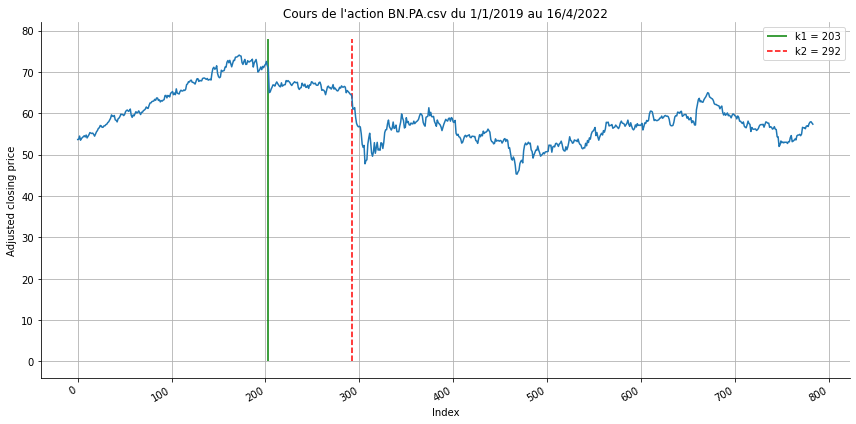

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6969277846059543, 'b1': 107.6727769921705, 'a2': 0.7007221963561775, 'b2': 58.171034400853806, 'k*': 302}
{'a1': 0.6974902178742197, 'b1': 90.77737149978472, 'a2': 0.7007543258734452, 'b2': 36.67606043584609, 'k*': 292}


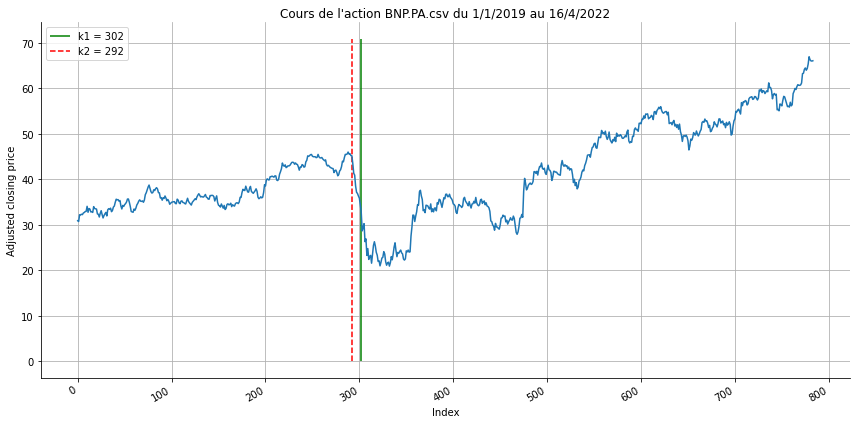

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.696214584605879, 'b1': 131.2366436271885, 'a2': 0.698220577034685, 'b2': 82.02566958379073, 'k*': 271}
{'a1': 0.6967278140457653, 'b1': 82.80354920237684, 'a2': 0.6984859259156557, 'b2': 47.926002500834606, 'k*': 296}


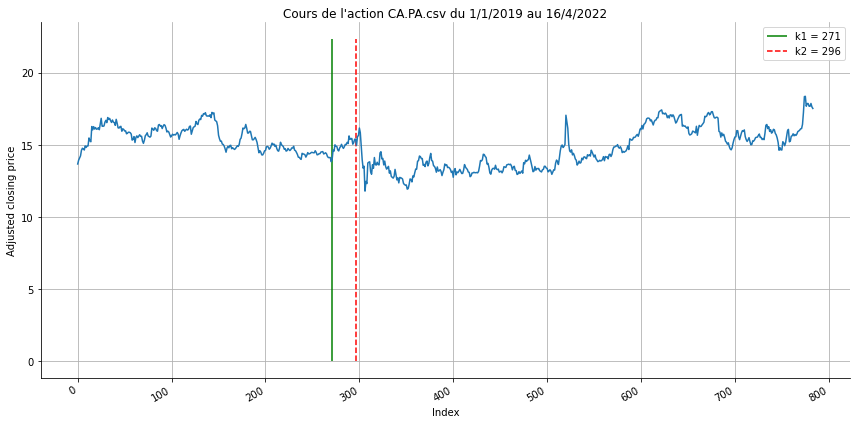

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6992891797151963, 'b1': 69.15254020083773, 'a2': 0.6975600716901331, 'b2': 110.23768694760285, 'k*': 402}
{'a1': 0.6996401964769888, 'b1': 45.925518070376754, 'a2': 0.6978380299582343, 'b2': 82.809666030816, 'k*': 403}


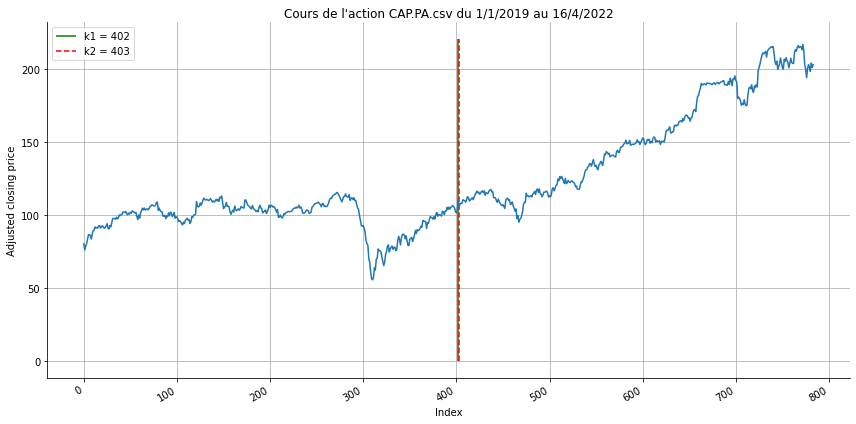

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.697470825785301, 'b1': 101.2627982041237, 'a2': 0.7006716669467002, 'b2': 55.15939245669008, 'k*': 302}
{'a1': 0.6977555897891654, 'b1': 67.67368422699533, 'a2': 0.7008758477928133, 'b2': 39.64508566636815, 'k*': 302}


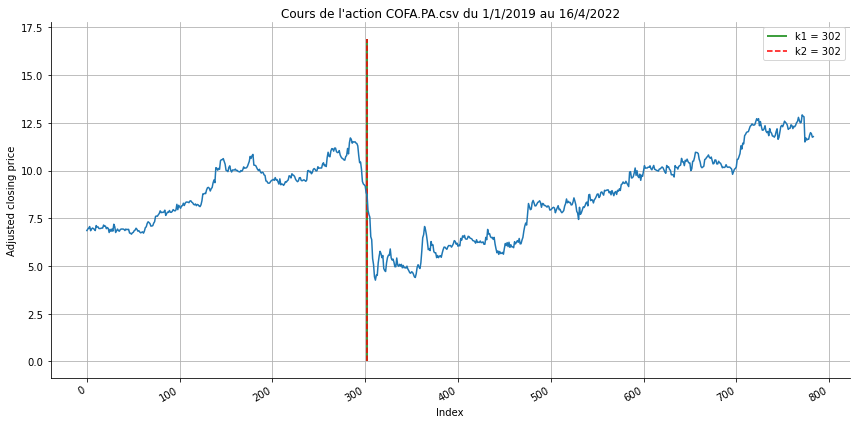

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6957870848747769, 'b1': 166.45100969265516, 'a2': 0.6994420321592446, 'b2': 69.04122797205858, 'k*': 301}
{'a1': 0.6960767506849406, 'b1': 134.9967639557154, 'a2': 0.6993288973974223, 'b2': 39.56718105338934, 'k*': 290}


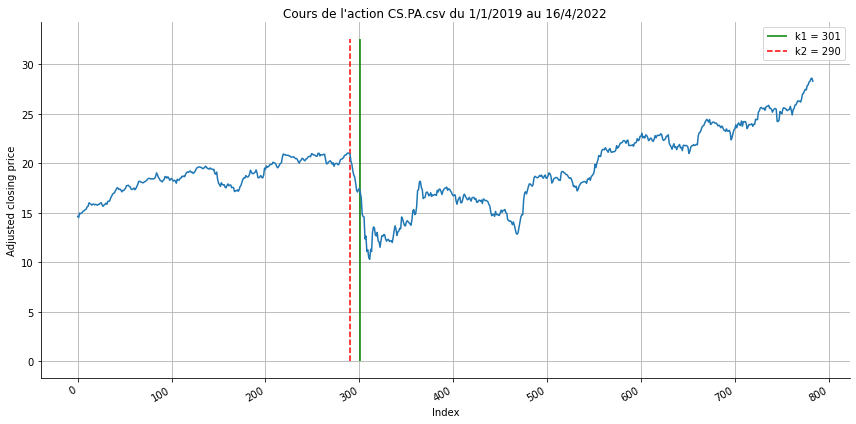

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6962139620073764, 'b1': 152.0002612723199, 'a2': 0.6998699414920868, 'b2': 60.46353096913735, 'k*': 298}
{'a1': 0.6964860620198632, 'b1': 129.91693483012983, 'a2': 0.6997795307398206, 'b2': 36.69177374725268, 'k*': 292}


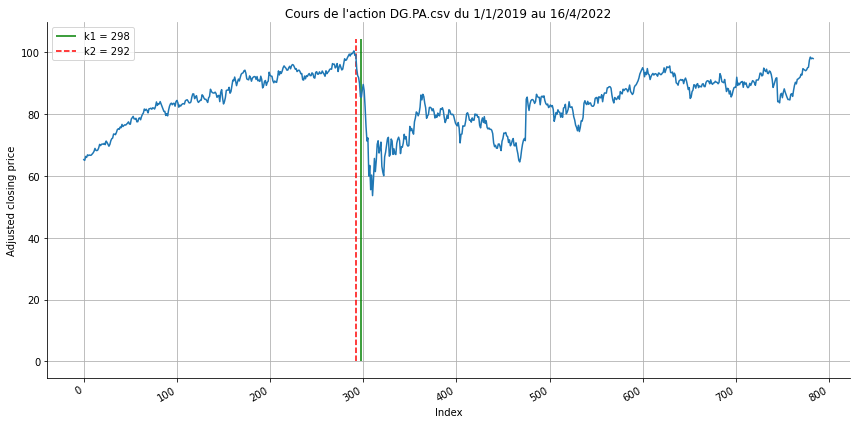

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.7095101557477946, 'b1': 26.845516116199448, 'a2': 0.6992443972829921, 'b2': 61.076946041647055, 'k*': 328}
{'a1': 0.7104534972458887, 'b1': 12.867917407063594, 'a2': 0.6998360956026333, 'b2': 44.3831280743897, 'k*': 329}


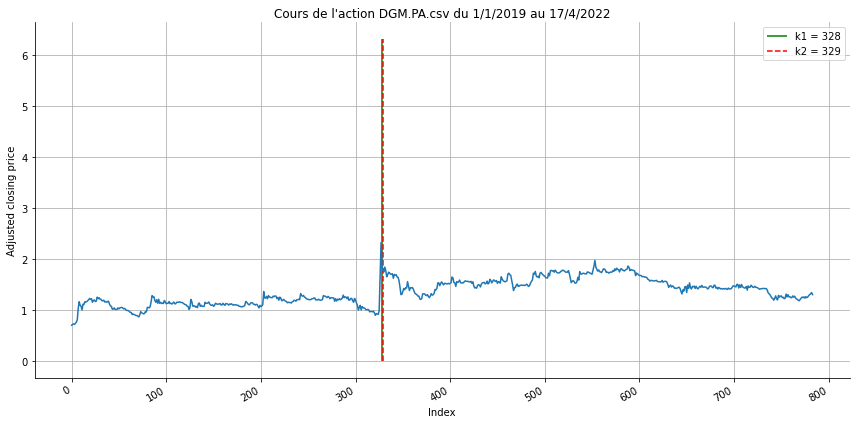

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6962386861658288, 'b1': 109.43952038158795, 'a2': 0.700037061000018, 'b2': 56.8085499652341, 'k*': 266}
{'a1': 0.696389357595574, 'b1': 89.5455086028523, 'a2': 0.6997384657512058, 'b2': 45.39800948263699, 'k*': 266}


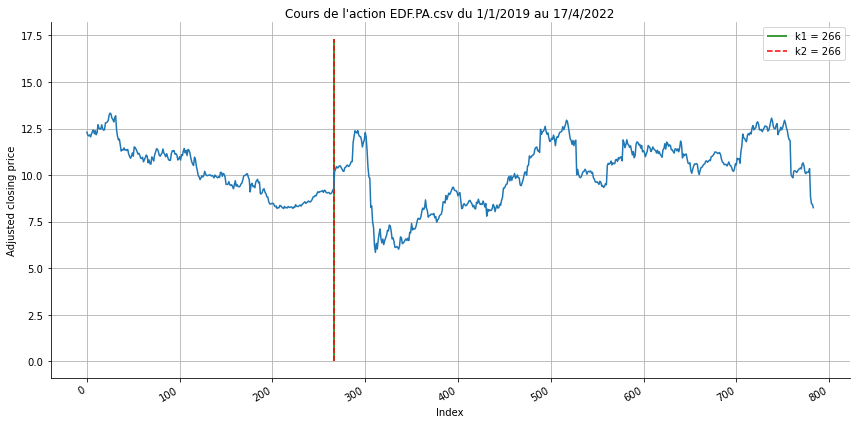

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6996218312307642, 'b1': 63.8094194330122, 'a2': 0.6959930638009335, 'b2': 141.14366742900793, 'k*': 476}
{'a1': 0.6997218015151001, 'b1': 41.916482056455735, 'a2': 0.6961224186263801, 'b2': 120.04837797718054, 'k*': 476}


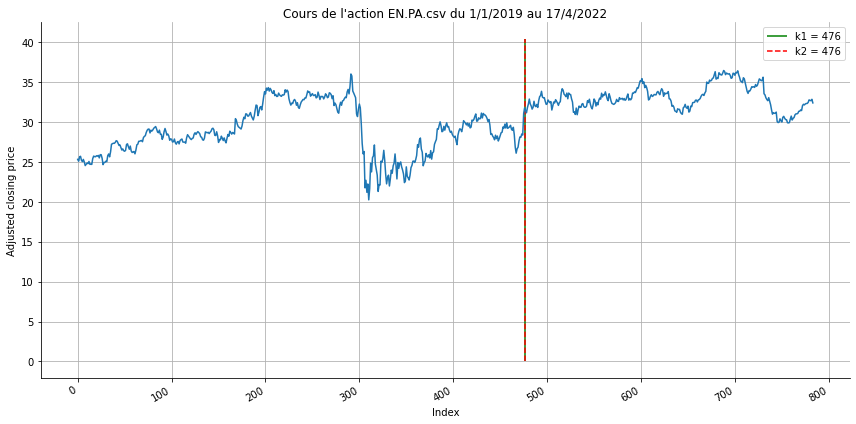

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6972884581813665, 'b1': 92.42743264576934, 'a2': 0.7024568201518695, 'b2': 45.90615952770498, 'k*': 301}
{'a1': 0.6977488653618719, 'b1': 77.49244654491724, 'a2': 0.7027085992024422, 'b2': 25.127400837130146, 'k*': 295}


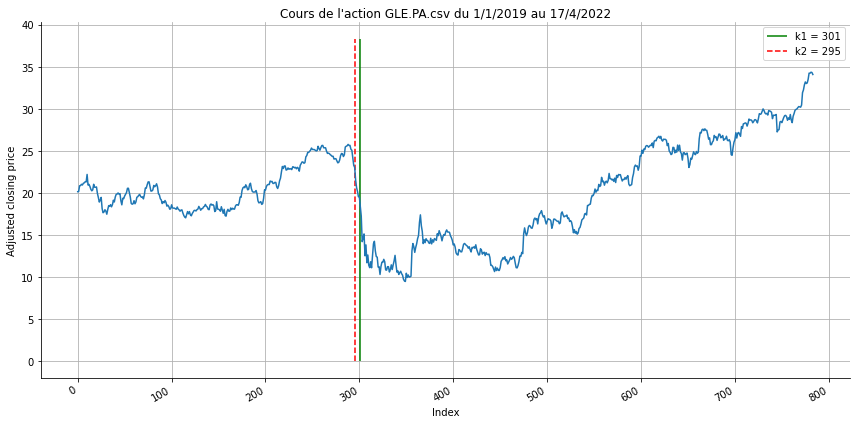

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.7018831087186633, 'b1': 47.268632298812975, 'a2': 0.6977615591008801, 'b2': 93.06088544151983, 'k*': 357}
{'a1': 0.7000322055843555, 'b1': 40.143821819956486, 'a2': 0.6978797955327656, 'b2': 70.31177593829703, 'k*': 357}


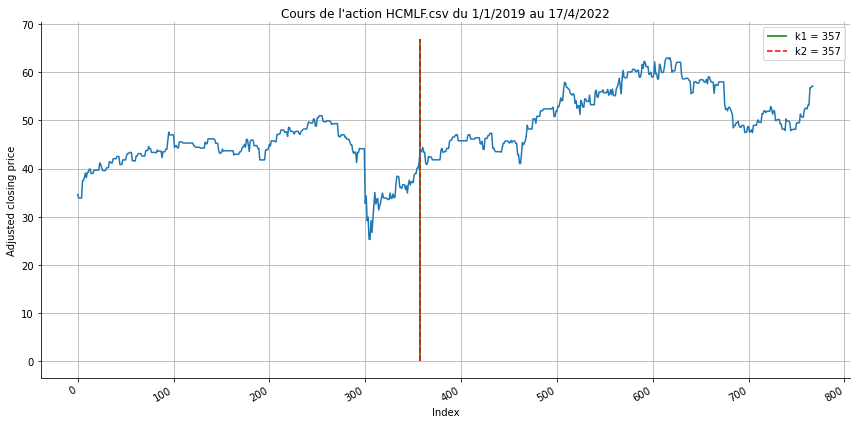

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6984617408345154, 'b1': 72.05006938269054, 'a2': 0.6961677141293345, 'b2': 137.50519157079745, 'k*': 480}
{'a1': 0.6987950379355423, 'b1': 45.862849037911616, 'a2': 0.6963458893174266, 'b2': 112.26809736070953, 'k*': 480}


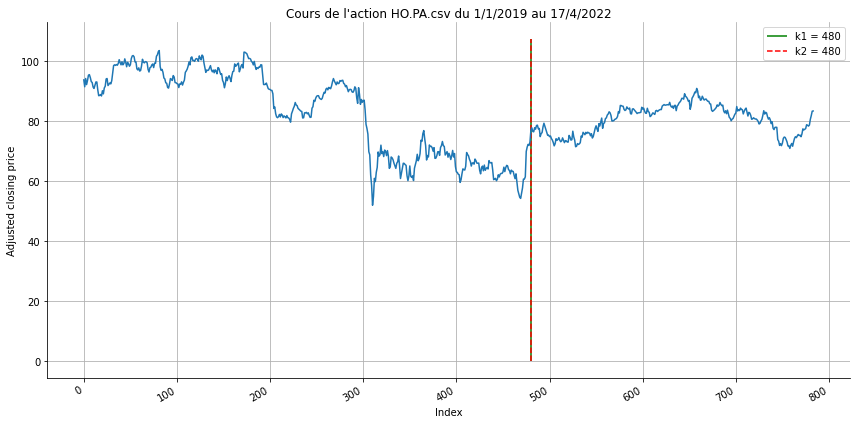

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.7185338281389324, 'b1': 34.06855832067184, 'a2': 0.6986177641309315, 'b2': 81.27534946763453, 'k*': 5}
{'a1': 0.7173941565498778, 'b1': 43.897286142341514, 'a2': 0.6989750580072847, 'b2': 58.35447409680523, 'k*': 5}


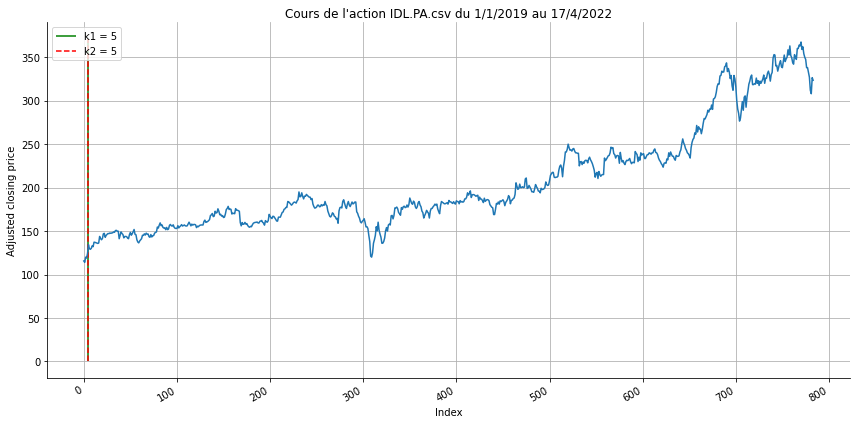

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.701041584818577, 'b1': 46.266911601566235, 'a2': 0.6981196532445537, 'b2': 84.13600677899655, 'k*': 341}
{'a1': 0.7007189388054014, 'b1': 33.34335068957514, 'a2': 0.6970108702658677, 'b2': 90.00976657704456, 'k*': 472}


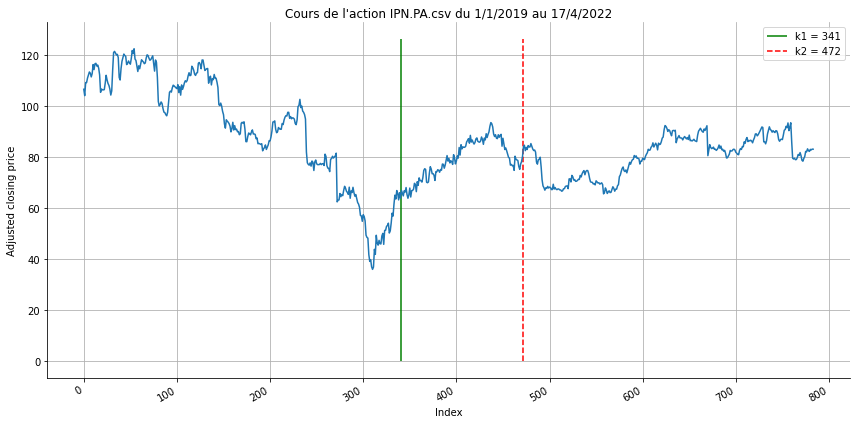

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6990427207754693, 'b1': 71.96226634894289, 'a2': 0.6976790131442452, 'b2': 96.34742267272193, 'k*': 372}
{'a1': 0.6992744095834525, 'b1': 50.55965539670658, 'a2': 0.6978783243819526, 'b2': 78.79030768135269, 'k*': 368}


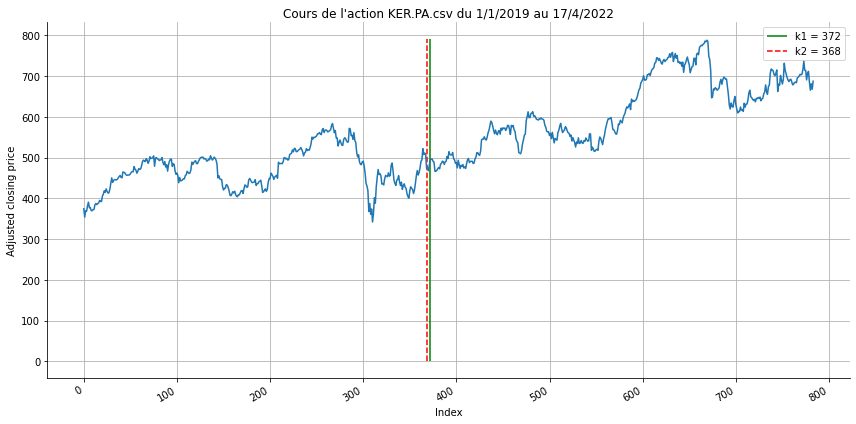

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.698752695407385, 'b1': 77.70548727491907, 'a2': 0.6964726872627492, 'b2': 138.3442477407, 'k*': 364}
{'a1': 0.6988993765667529, 'b1': 41.13093214733371, 'a2': 0.6966091540714415, 'b2': 115.51175038895343, 'k*': 365}


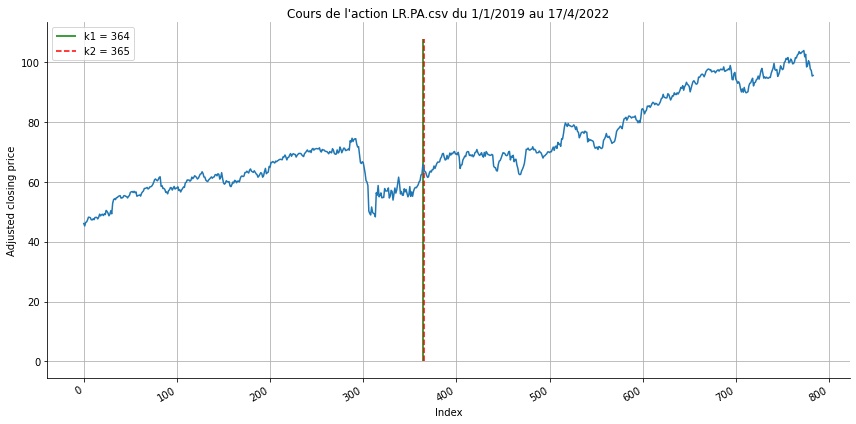

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6984892085202332, 'b1': 86.24292695431865, 'a2': 0.6972499313638363, 'b2': 113.41742919046408, 'k*': 477}
{'a1': 0.6987504094899557, 'b1': 61.171124454926186, 'a2': 0.6974249054156432, 'b2': 95.8124083327954, 'k*': 478}


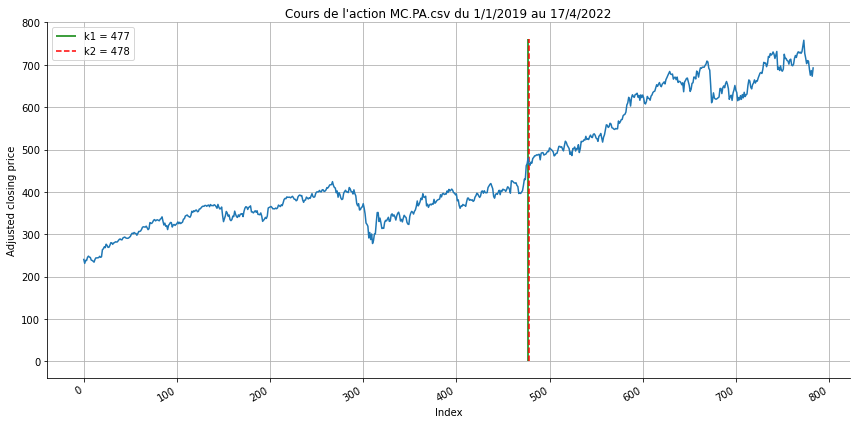

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6989525910757318, 'b1': 72.03642814194342, 'a2': 0.697173943582876, 'b2': 114.05202256129627, 'k*': 364}
{'a1': 0.699011653793474, 'b1': 47.27743474967659, 'a2': 0.6974700442770976, 'b2': 94.52620342004259, 'k*': 368}


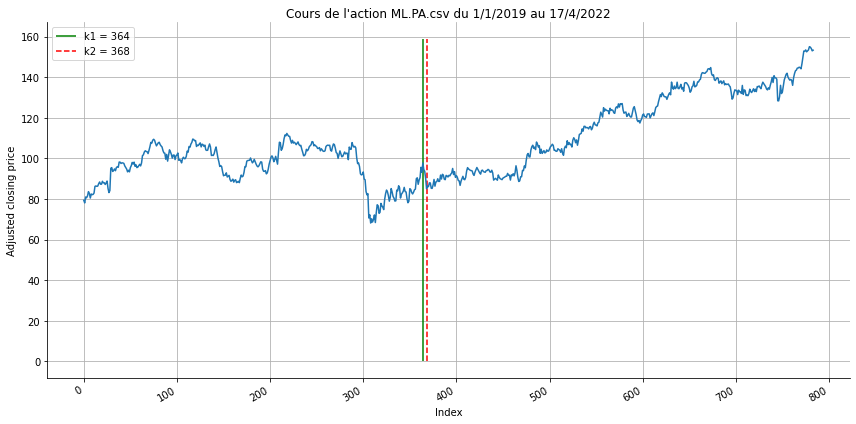

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6961649568588844, 'b1': 158.7503857344348, 'a2': 0.6973213497255473, 'b2': 106.03984129525183, 'k*': 211}
{'a1': 0.6962711636047648, 'b1': 130.9861718388015, 'a2': 0.6976025261649055, 'b2': 69.89101574382337, 'k*': 211}


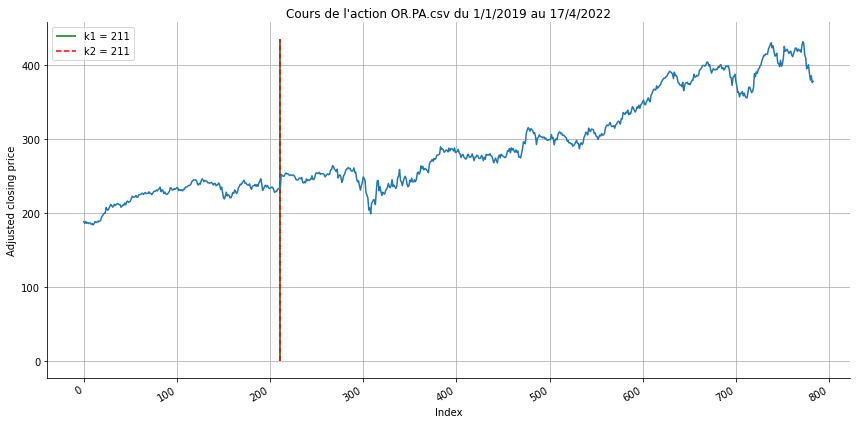

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6951605407854887, 'b1': 189.94119472512182, 'a2': 0.6968174732424142, 'b2': 104.14247354776381, 'k*': 285}
{'a1': 0.695239869667547, 'b1': 160.2303180275389, 'a2': 0.6969834860394138, 'b2': 60.18181007195531, 'k*': 285}


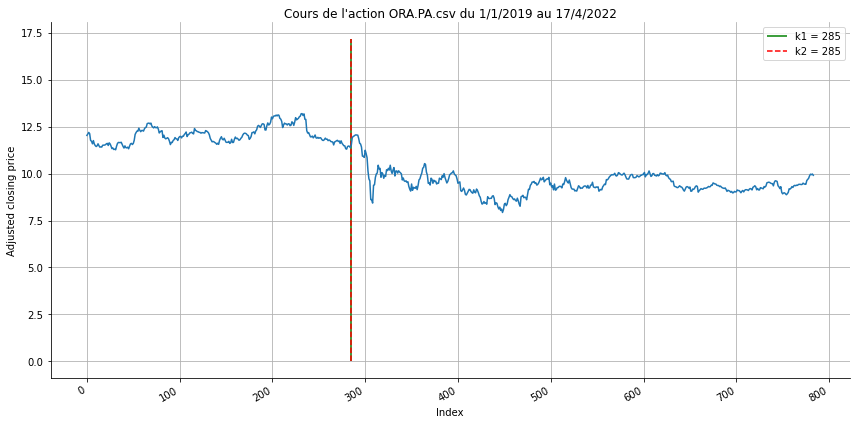

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6995009392824892, 'b1': 61.54801837674094, 'a2': 0.6971095945289224, 'b2': 126.29139732612505, 'k*': 491}
{'a1': 0.6963774103015612, 'b1': 106.69045626965045, 'a2': 0.6998924935515993, 'b2': 43.995317348996515, 'k*': 292}


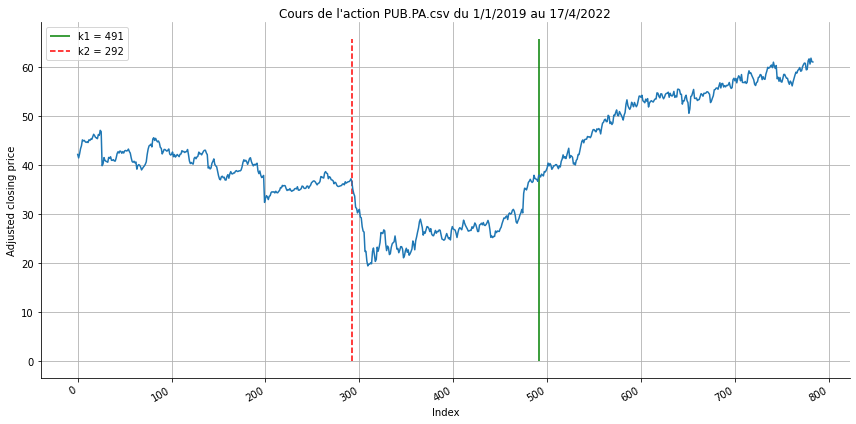

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6968536203850165, 'b1': 112.05909392727185, 'a2': 0.6960214133244601, 'b2': 160.65562191580094, 'k*': 489}
{'a1': 0.6970209548099173, 'b1': 78.87404241070381, 'a2': 0.6961799149560944, 'b2': 126.90858586149045, 'k*': 475}


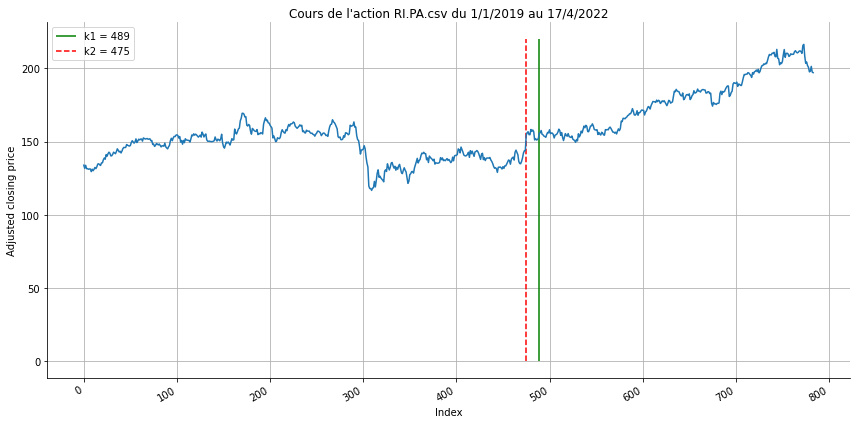

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6968552448071108, 'b1': 80.04605508434261, 'a2': 0.7024018925959211, 'b2': 45.21667207146761, 'k*': 302}
{'a1': 0.7018249387210379, 'b1': 31.651150021684657, 'a2': 0.698518429379702, 'b2': 63.934325330983754, 'k*': 486}


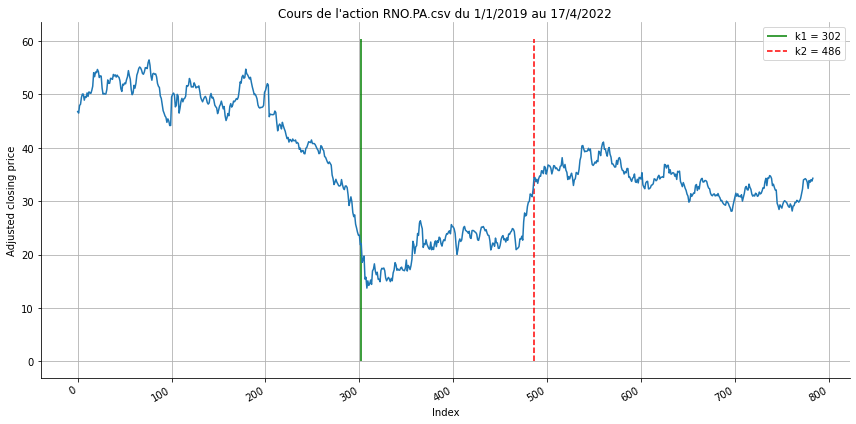

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


In [ ]:

for i in range(len(Liste_donnees)):
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')
    F1 = First_Method_analytic(Y(data[i]))  #Ici on doit changer l'indice pour qu'on puisse tester sur tous les bases de données
    F2 = Second_Method_log_vrais(Y(data[i]))
    print(F1)
    print(F2)
    cours_action(data[i],data_time[i],Liste_donnees[i],F1['k*'],F2['k*']) 

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6966278241468489, 'b1': 114.61803117727031, 'a2': 0.7020940562833208, 'b2': 45.02116767139253, 'k*': 305}
{'a1': 0.696995615741992, 'b1': 93.3112949719367, 'a2': 0.7018858319569359, 'b2': 29.24259269311598, 'k*': 300}


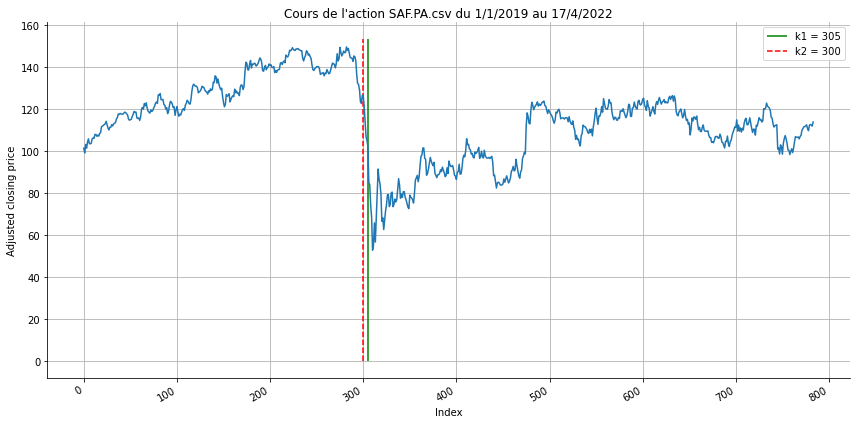

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6969163265748676, 'b1': 112.60614595029796, 'a2': 0.6956857979518702, 'b2': 164.65262900192258, 'k*': 477}
{'a1': 0.6971372548313033, 'b1': 82.96668798341759, 'a2': 0.6958424942722352, 'b2': 137.82650019896272, 'k*': 477}


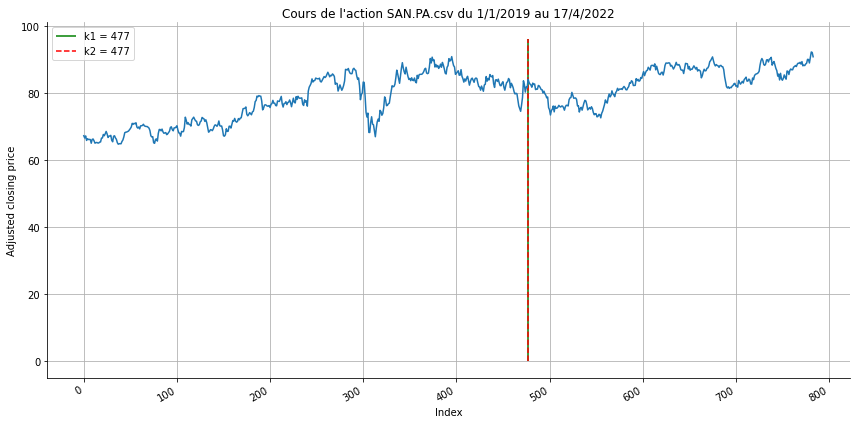

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6988351819629229, 'b1': 77.6070599675387, 'a2': 0.6936000313861317, 'b2': 1027.9265557692129, 'k*': 587}
{'a1': 0.6989464120065618, 'b1': 40.30927612305209, 'a2': 0.6936452899030081, 'b2': 693.6804901723789, 'k*': 581}


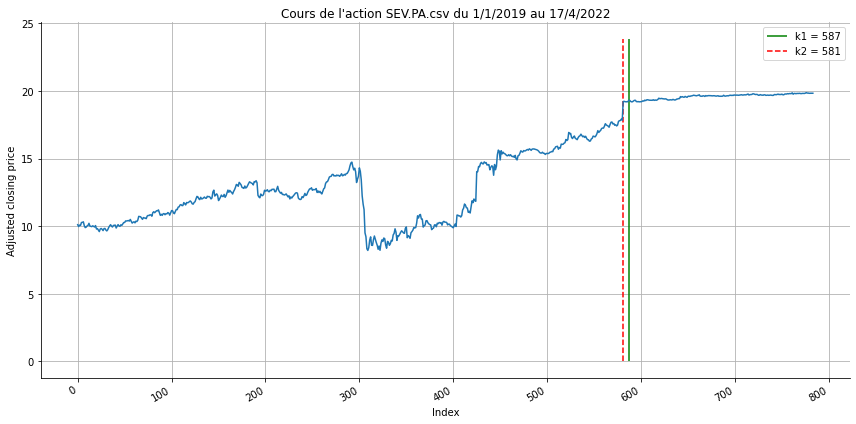

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6970319380376908, 'b1': 110.89660673070061, 'a2': 0.6999840775443742, 'b2': 65.68453782936415, 'k*': 300}
{'a1': 0.6994582447092995, 'b1': 48.594224085711915, 'a2': 0.6977015935125712, 'b2': 88.19657669442765, 'k*': 516}


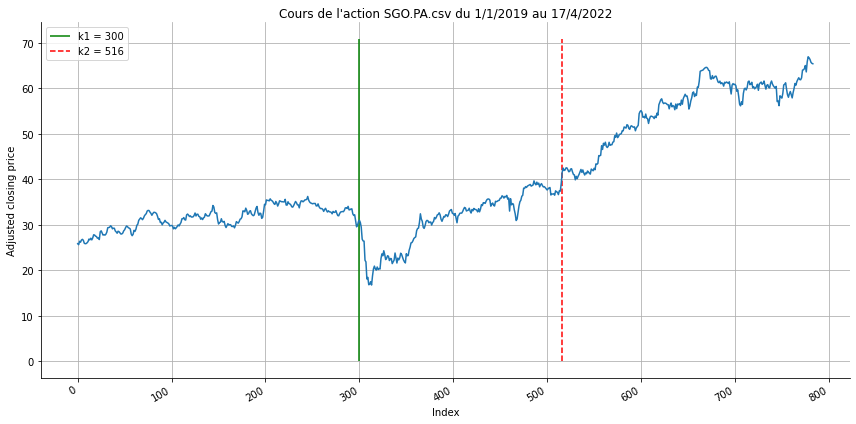

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6970741763063684, 'b1': 131.85212099229867, 'a2': 0.6984956452903436, 'b2': 83.05058001683287, 'k*': 290}
{'a1': 0.6989614916086208, 'b1': 52.34153276109167, 'a2': 0.6973093395771612, 'b2': 96.97272201031805, 'k*': 371}


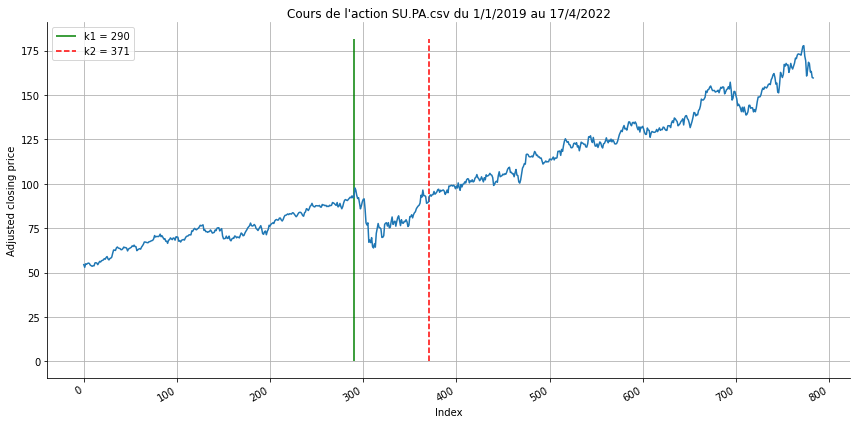

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6955492905176699, 'b1': 147.1544913263672, 'a2': 0.6998149103005488, 'b2': 62.30317824790429, 'k*': 301}
{'a1': 0.695727352708508, 'b1': 134.62286801236965, 'a2': 0.6996725157647627, 'b2': 40.157144934767466, 'k*': 292}


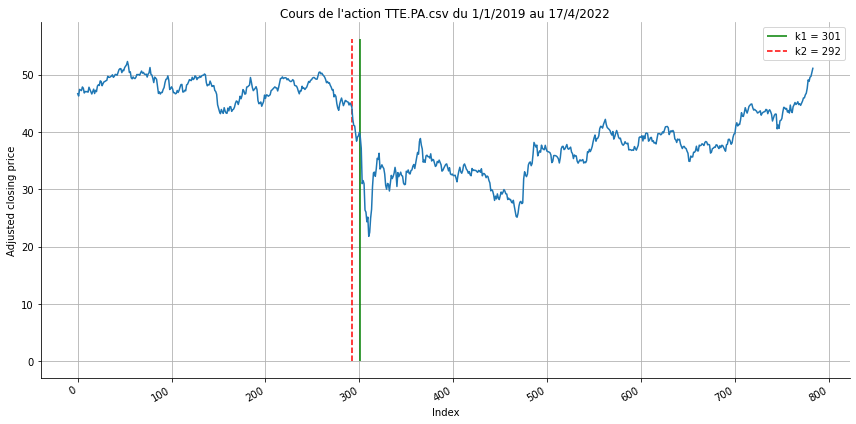

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6962943389203347, 'b1': 170.97469923024468, 'a2': 0.6985415532960607, 'b2': 76.83902674304214, 'k*': 295}
{'a1': 0.6963741142894169, 'b1': 148.9294995509867, 'a2': 0.6985746531281444, 'b2': 58.45838975562666, 'k*': 295}


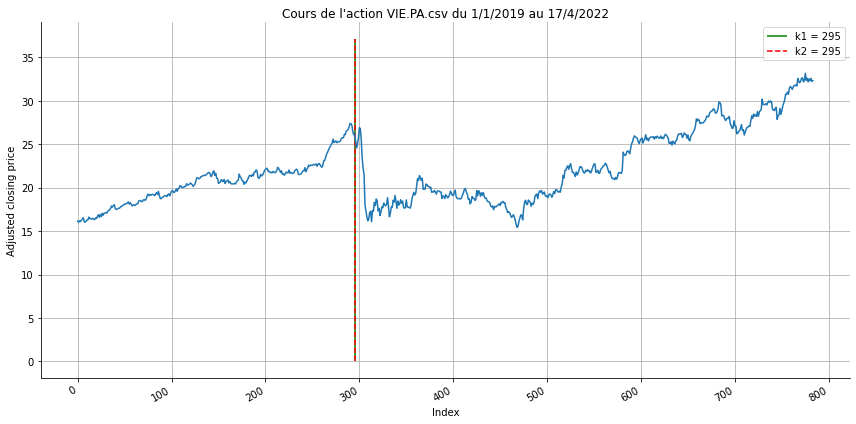

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.6977593612625363, 'b1': 93.68969567000103, 'a2': 0.7368128623089061, 'b2': 8.146797224340444, 'k*': 687}
{'a1': 0.6972426596611045, 'b1': 74.96192505842721, 'a2': 0.6986579276003682, 'b2': 32.82676682445393, 'k*': 542}


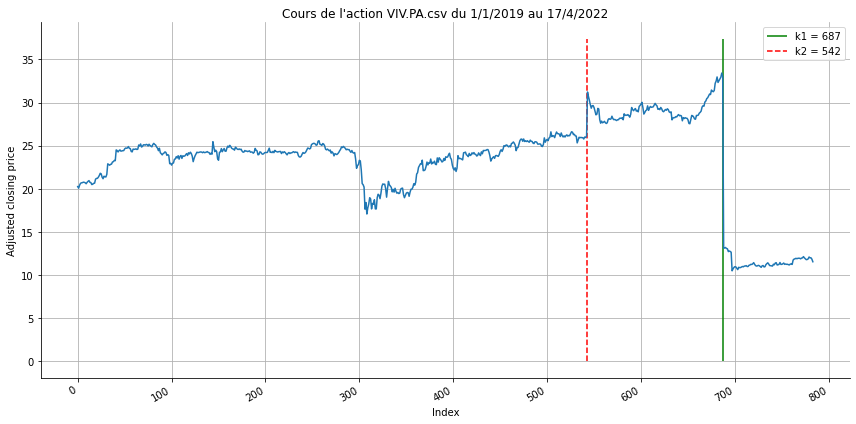

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------



{'a1': 0.7181126069751571, 'b1': 14.6835684256946, 'a2': 0.7029969968480475, 'b2': 38.27956682742823, 'k*': 340}
{'a1': 0.7038804085137634, 'b1': 22.889927478721255, 'a2': 0.7017982530784104, 'b2': 37.95836663903993, 'k*': 486}


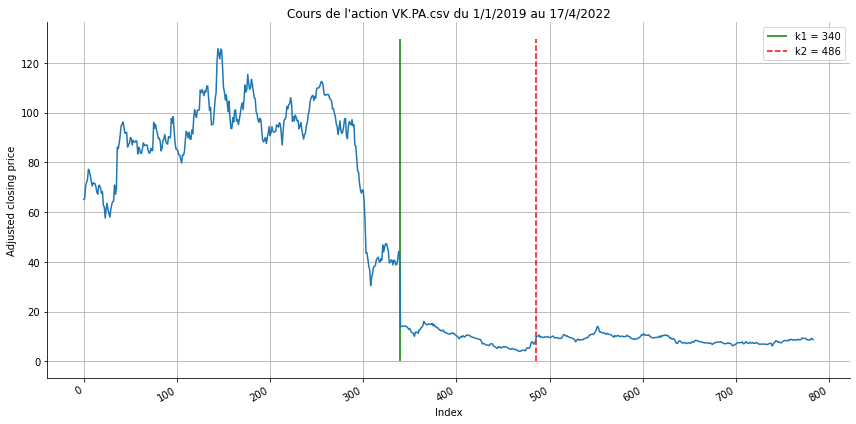

In [12]:

for i in range(29,len(Liste_donnees)):
    print('-----------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------')
    F1 = First_Method_analytic(Y(data[i]))  #Ici on doit changer l'indice pour qu'on puisse tester sur tous les bases de données
    F2 = Second_Method_log_vrais(Y(data[i]))
    print(F1)
    print(F2)
    cours_action(data[i],data_time[i],Liste_donnees[i],F1['k*'],F2['k*']) 

## Test sur CAC40 méthode de Log vrai semblence

## Les graphes de méthode analytique + Vrai semblance

In [11]:
# tracée du cours des differentes actions de l'indice 
def cours_action(data,date,nom_action,k1,k2):
        #Changer ici l'indice
    import datetime
    start=datetime.datetime(2019,1,1)
    end=datetime.datetime.today()
    import matplotlib.pyplot as plt
    fig=plt.figure(figsize=(12,6))
    plt.gcf().subplots_adjust(bottom=0.25)
    ax=fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel('Index')
    ax.set_ylabel('Adjusted closing price')
        
    plt.plot(data)
    
    #Ploter deux lignes verticale des K trouvés pour les deux modèles
    plt.vlines(k1,0, max(data)+4, colors='g',label = "k1 = "+str(k1))
    plt.legend()

    plt.vlines(k2, 0, max(data)+4, colors='r', linestyles= 'dashed',label = "k2 = "+str(k2))
    plt.legend()


    plt.title('Cours de l\'action %s du %s/%s/%s au %s/%s/%s'%(nom_action,start.day,start.month,start.year,end.day,end.month,end.year))
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    fig.autofmt_xdate() # Corriger le chevauchement
    plt.tight_layout()
    plt.show()
    plt.close()



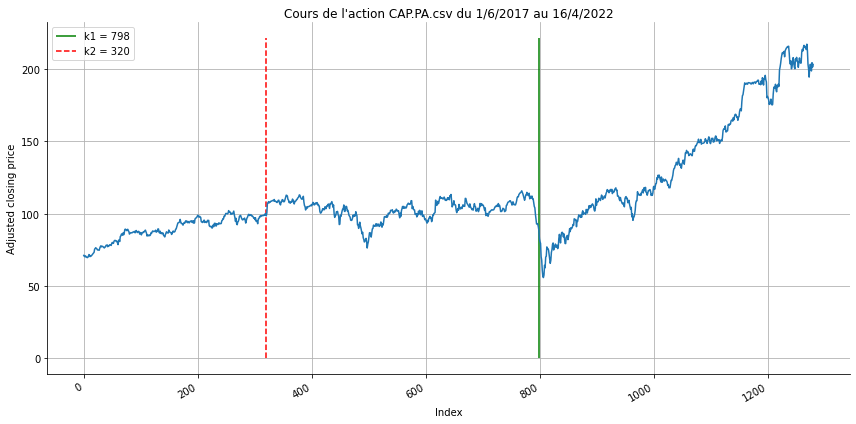

In [96]:
cours_action(data[29],data_time[29],Liste_donnees[29],F1['k*'],F2['k*'])    #changer l'indice

#Prendre un screen de chaque graphe dans vos indices affectés que vous allez trouver sur excel ainsi stocker les valeurs 
#dans les tableaux de l'excel pour qui vous puisse copier les valeurs ainsi coller screen du graphe quand on va créer 
#un tableau sur Overleaf